## Capstone Part 6 - Age model

In [ ]:
# Reference made from to build model:
# https://www.kaggle.com/code/hechtjp/h-m-eda-rule-base-by-customer-age

The objective of this notebook is to create an alternative model to LGBM and base model in parts 2 and 4. 

This notebook was run on Google Colab Pro+ account, using rapids and cuDF to shorten run time. Below are some of the commands to aid with installation to enable cuDF to be imported.

As the notebook was optimised to run on Google Colab, the relative references are kept in order to let the notebook run on Colab.

In [ ]:
# import libraries
# === General ===
import sys, warnings, time, os, copy, random, cudf
warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.max_columns', None)
# pd.set_option("display.max_colwidth", 10000)
import seaborn as sns
sns.set()
from pathlib import Path
from datetime import datetime, timedelta

## Steps for cuDF installation onto Colab

Below are the steps to enable running of cuDF installation onto Colab. As I will be using a virtual machine, the same steps will need to be repeated each time I start Colab. 

In [ ]:
#!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
#!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
#!bash rapidsai-csp-utils/colab/update_gcc.sh
#import os
#os._exit(00)

In [ ]:
#import condacolab
#condacolab.install()

In [ ]:
# you can now run the rest of the cells as normal
#import condacolab
#condacolab.check()

In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
#!python rapidsai-csp-utils/colab/install_rapids.py stable
#import os
#os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
#os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
#os.environ['CONDA_PREFIX'] = '/usr/local'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
DEBUG = False
PATH_INPUT = r'/content/drive/MyDrive/datasets/'

In [ ]:
# read csv
customers = cudf.read_csv(PATH_INPUT + 'customers.csv', usecols=['customer_id', 'age'])
articles = cudf.read_csv(PATH_INPUT + 'articles.csv', usecols=['article_id', "product_group_name", "perceived_colour_master_name"])
train = cudf.read_csv(PATH_INPUT + 'transactions_train.csv', usecols=['t_dat', 'customer_id', 'article_id'],
                               dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string'})

In [ ]:
customers=customers[['customer_id', 'age']]

In [ ]:
customers

,customer_id,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,24.0
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,21.0
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,21.0
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,18.0


In [ ]:
articles = articles[['article_id', 'product_group_name', 'perceived_colour_master_name']]

In [ ]:
articles.head()

,article_id,product_group_name,perceived_colour_master_name
0,108775015,Garment Upper body,Black
1,108775044,Garment Upper body,White
2,108775051,Garment Upper body,White
3,110065001,Underwear,Black
4,110065002,Underwear,White


## Create age bins

In [ ]:
customers = customers.to_pandas()
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
customers['age_bins'] = pd.cut(customers['age'], listBin)

In [ ]:
customers.head()

,customer_id,age,age_bins
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,"(39, 49]"
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0,"(19, 29]"
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0,"(19, 29]"
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0,"(49, 59]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0,"(49, 59]"


In [ ]:
customers.shape

(1371980, 3)

In [ ]:
x = customers[customers['age_bins'].isnull()].shape[0]
print(f'{x} customer_id do not have age information.\n')

15861 customer_id do not have age information.



In [ ]:
customers[customers['age_bins'].isnull()]

,customer_id,age,age_bins
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,NaN
54,0002b9088196900626214bcdc6d5f3d85f38fb462a4806...,NaN,NaN
99,0004690d2b68d5175697d197a86065595ef7b49c7c051b...,NaN,NaN
138,0005cd85a6220e1f1c582c7ff9175efe7d7c16d184c5ba...,NaN,NaN
148,00060d2f1e63f2b95268b8573996b9aa5612a3efc97c71...,NaN,NaN
...,...,...,...
1371583,ffecf38e80a8d73c9c6fb6db193e559dbd5374747b4b88...,NaN,NaN
1371637,ffefa8fa76909f9b9b3c14680d3e00dae891de5d1522f9...,NaN,NaN
1371712,fff2f8b52ac6983cf9b2332d1a9bfe0ef38349a8d5392e...,NaN,NaN
1371888,fffb069903e91c2ea4d665851b821c3f812e184119e5a8...,NaN,NaN


I did not wish to do deductive imputation on the null values for age. This might create an unintentional skewing for each age bin. As such, I let null remain as its own age bin, and allowed the model to predict it separately.

## Transaction 5 weeks

In [ ]:
train.head()

,t_dat,customer_id,article_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004


In [ ]:
train['t_dat'] = cudf.to_datetime(train['t_dat'])
train.set_index('t_dat', inplace=True)

In [ ]:
dfRecent = train.loc['2020-08-14' : '2020-09-21']
dfRecent= dfRecent.to_pandas()
dfRecent.head()

,customer_id,article_id
t_dat,,
2020-08-14,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,884319008
2020-08-14,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,921226001
2020-08-14,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,706016001
2020-08-14,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,881244001
2020-08-14,00025f8226be50dcab09402a2cacd520a99e112fe01fdd...,781613016


In [ ]:
dfRecent = dfRecent.merge(customers, on='customer_id', how='inner')

In [ ]:
dfRecent = dfRecent.groupby(['age_bins', 'article_id']).count().reset_index().rename(columns={'customer_id': 'counts'})

listUniBins = dfRecent['age_bins'].unique().tolist()

dict100 = {}
for uniBin in listUniBins:
    dfTemp = dfRecent[dfRecent['age_bins'] == uniBin]
    dfTemp = dfTemp.sort_values(by='counts', ascending=False)
    dict100[uniBin] = dfTemp.head(100)['article_id'].values.tolist()

df100 = pd.DataFrame([dict100]).T.rename(columns={0:'top100'})

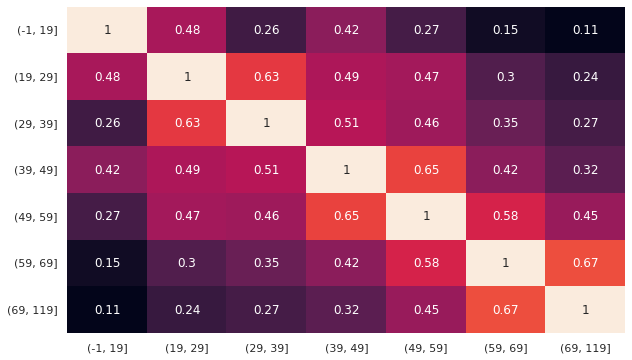

In [ ]:
for index in df100.index:
    df100[index] = [len(set(df100.at[index, 'top100']) & set(df100.at[x, 'top100']))/100 for x in df100.index]

df100 = df100.drop(columns='top100')
plt.figure(figsize=(10, 6))
sns.heatmap(df100, annot=True, cbar=False);

There is generally some correlation between the nearest age bin. however, it seems to be around 0.5 to 0.7. As such, I believe there is no real need to further split out age bins

In [ ]:
df100

,"(-1, 19]","(19, 29]","(29, 39]","(39, 49]","(49, 59]","(59, 69]","(69, 119]"
"(-1, 19]",1.00,0.48,0.26,0.42,0.27,0.15,0.11
"(19, 29]",0.48,1.00,0.63,0.49,0.47,0.30,0.24
"(29, 39]",0.26,0.63,1.00,0.51,0.46,0.35,0.27
"(39, 49]",0.42,0.49,0.51,1.00,0.65,0.42,0.32
"(49, 59]",0.27,0.47,0.46,0.65,1.00,0.58,0.45
"(59, 69]",0.15,0.30,0.35,0.42,0.58,1.00,0.67
"(69, 119]",0.11,0.24,0.27,0.32,0.45,0.67,1.00


In [ ]:
N = 12
listUniBins = customers['age_bins'].unique().tolist()

In [ ]:
for uniBin in listUniBins:
    df  = cudf.read_csv(PATH_INPUT + 'transactions_train.csv',
                            usecols= ['t_dat', 'customer_id', 'article_id'], 
                            dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string'})
    if str(uniBin) == 'nan':
        dfCustomersTemp = customers[customers['age_bins'].isnull()]
    else:
        dfCustomersTemp = customers[customers['age_bins'] == uniBin]
    
    dfCustomersTemp = dfCustomersTemp.drop(['age_bins'], axis=1)
    dfCustomersTemp = cudf.from_pandas(dfCustomersTemp)
    
    df = df.merge(dfCustomersTemp[['customer_id', 'age']], on='customer_id', how='inner')
    print(f'The shape of scope transaction for {uniBin} is {df.shape}. \n')
          
    df ['customer_id'] = df ['customer_id'].str[-16:].str.hex_to_int().astype('int64')
    df['t_dat'] = cudf.to_datetime(df['t_dat'])
    last_ts = df['t_dat'].max()

    tmp = df[['t_dat']].copy().to_pandas()
    tmp['dow'] = tmp['t_dat'].dt.dayofweek
    tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')
    tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')

    df['ldbw'] = tmp['ldbw'].values
    
    weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
    weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})
    
    df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')
    
    weekly_sales = weekly_sales.reset_index().set_index('article_id')

    df = df.merge(
        weekly_sales.loc[weekly_sales['ldbw']==last_ts, ['count']],
        on='article_id', suffixes=("", "_targ"))

    df['count_targ'].fillna(0, inplace=True)
    del weekly_sales
    
    df['quotient'] = df['count_targ'] / df['count']
    
    target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
    general_pred = target_sales.nlargest(N).index.to_pandas().tolist()
    general_pred = ['0' + str(article_id) for article_id in general_pred]
    general_pred_str =  ' '.join(general_pred)
    del target_sales
    
    purchase_dict = {}

    tmp = df.copy().to_pandas()
    tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)
    tmp['dummy_1'] = 1 
    tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)

    a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
    tmp['y'] = a / np.sqrt(tmp['x']) + b * np.exp(-c*tmp['x']) - d

    tmp['dummy_0'] = 0 
    tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)
    tmp['value'] = tmp['quotient'] * tmp['y'] 

    tmp = tmp.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
    tmp = tmp.reset_index()

    tmp = tmp.loc[tmp['value'] > 0]
    tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)
    tmp = tmp.loc[tmp['rank'] <= 12]

    purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)
    purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
    purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
    purchase_df['prediction'] = purchase_df['prediction'].str.strip()
    purchase_df = cudf.DataFrame(purchase_df)
    
    sub  = cudf.read_csv(PATH_INPUT + 'sample_submission.csv',
                            usecols= ['customer_id'], 
                            dtype={'customer_id': 'string'})
    
    numCustomers = sub.shape[0]
    
    sub = sub.merge(dfCustomersTemp[['customer_id', 'age']], on='customer_id', how='inner')

    sub['customer_id2'] = sub['customer_id'].str[-16:].str.hex_to_int().astype('int64')

    sub = sub.merge(purchase_df, left_on = 'customer_id2', right_on = 'customer_id', how = 'left',
                   suffixes = ('', '_ignored'))

    sub = sub.to_pandas()
    sub['prediction'] = sub['prediction'].fillna(general_pred_str)
    sub['prediction'] = sub['prediction'] + ' ' +  general_pred_str
    sub['prediction'] = sub['prediction'].str.strip()
    sub['prediction'] = sub['prediction'].str[:131]
    sub = sub[['customer_id', 'prediction']]
    sub.to_csv(f'submission_' + str(uniBin) + '.csv',index=False)
    print(f'Saved prediction for {uniBin}. The shape is {sub.shape}. \n')
    print('-'*50)
print('Finished.\n')
print('='*50)

The shape of scope transaction for (39.0, 49.0] is (4908363, 4). 

Saved prediction for (39.0, 49.0]. The shape is (204118, 2). 

--------------------------------------------------
The shape of scope transaction for (19.0, 29.0] is (13058587, 4). 

Saved prediction for (19.0, 29.0]. The shape is (528358, 2). 

--------------------------------------------------
The shape of scope transaction for (49.0, 59.0] is (5136958, 4). 

Saved prediction for (49.0, 59.0]. The shape is (226242, 2). 

--------------------------------------------------
The shape of scope transaction for nan is (140258, 4). 

Saved prediction for nan. The shape is (15861, 2). 

--------------------------------------------------
The shape of scope transaction for (29.0, 39.0] is (6428863, 4). 

Saved prediction for (29.0, 39.0]. The shape is (234068, 2). 

--------------------------------------------------
The shape of scope transaction for (69.0, 119.0] is (220067, 4). 

Saved prediction for (69.0, 119.0]. The shape i

## Submission

In [ ]:
for i, uniBin in enumerate(listUniBins):
    dfTemp  = cudf.read_csv(f'submission_' + str(uniBin) + '.csv')
    if i == 0:
        dfSub = dfTemp
    else:
        dfSub = cudf.concat([dfSub, dfTemp], axis=0)

assert dfSub.shape[0] == numCustomers, f'The number of dfSub rows is not correct. {dfSub.shape[0]} vs {numCustomers}.'

dfSub.to_csv('/content/drive/MyDrive/datasets/age.csv', index=False)
print(f'Saved age.csv.')

Saved age.csv.


Kaggle score returned MAP@ 12 of 0.0227, which is highest so far.